# MOwNiT 
## Laboratorium 5

### 1. Tablice wielowymiarowe i mnożenie macierzy w Julii

#### Wersja naiwna

In [1]:
# mnożenie macierzy - wersja naiwna
function naive_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

naive_multiplication (generic function with 1 method)

#### Wersja ulepszona

In [2]:
# poprawiona funkcja korzytająca z powyższego oraz z faktu, że
# można zmieniać kolejność operacji dodawania (a co za tym idzie kolejnosc petli).
function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

better_multiplication (generic function with 1 method)

#### Porównanie wersji

In [3]:
function naive_time(A,B)
    @elapsed naive_multiplication(A,B)
end

function better_time(A,B)
    @elapsed better_multiplication(A, B)
end

function blas_time(A,B)
    @elapsed A*B
end

blas_time (generic function with 1 method)

In [4]:
using DataFrames
df = DataFrame(length = Int64[], version = String[], time = Float64[])

r = 100:100:1000
for i = r
    for j = 1:10
        A = rand(i,i)
        B = rand(i,i)
        push!(df, [i "naive" naive_time(A,B)])
        push!(df, [i "better" better_time(A,B)])
        push!(df, [i "blas" blas_time(A,B)])
    end
end

In [5]:
df

,length,version,time
,Int64,String,Float64
1,100,naive,0.0026672
2,100,better,0.0010339
3,100,blas,0.003341
4,100,naive,0.0027339
5,100,better,0.0010852
6,100,blas,0.0006972
7,100,naive,0.0023791
8,100,better,0.0009657
9,100,blas,0.0006348


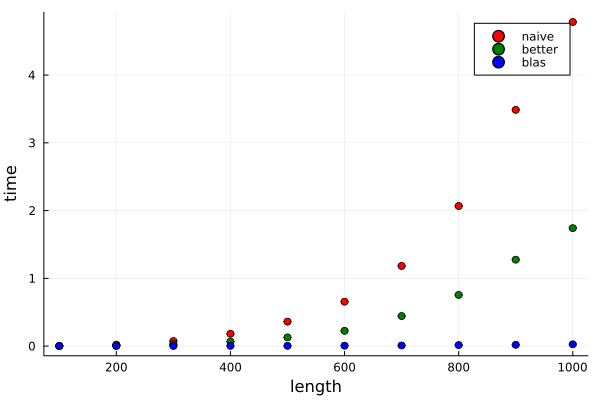

In [6]:
dfgrouped = groupby(df, [:length, :version])
using Statistics
using Plots
df_to_plot = combine(dfgrouped, "time" => mean, "time" => std)

scatter([ df_to_plot[df_to_plot[:,2] .== "naive", :].length df_to_plot[df_to_plot[:,2] .== "better", :].length df_to_plot[df_to_plot[:,2] .== "blas", :].length],
    [ df_to_plot[df_to_plot[:,2] .== "naive", :].time_mean  df_to_plot[df_to_plot[:,2] .== "better", :].time_mean df_to_plot[df_to_plot[:,2] .== "blas", :].time_mean ],
    colour = [:red :green :blue],
    yerr = df_to_plot.time_std,
    label = [ "naive" "better" "blas"],
    xlab = "length",
    ylab = "time"
)

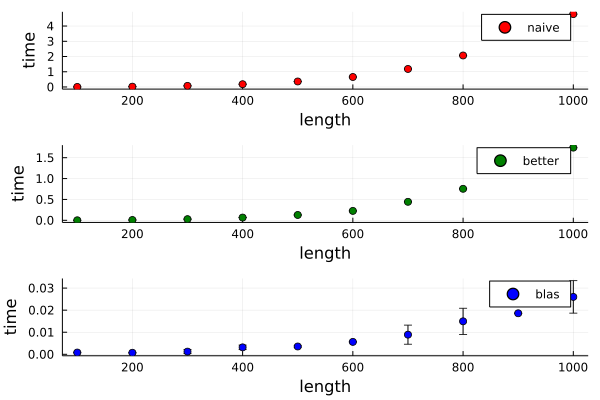

In [7]:
scatter([ df_to_plot[df_to_plot[:,2] .== "naive", :].length df_to_plot[df_to_plot[:,2] .== "better", :].length df_to_plot[df_to_plot[:,2] .== "blas", :].length],
    [ df_to_plot[df_to_plot[:,2] .== "naive", :].time_mean  df_to_plot[df_to_plot[:,2] .== "better", :].time_mean df_to_plot[df_to_plot[:,2] .== "blas", :].time_mean ],
    colour = [:red :green :blue],
    yerr = df_to_plot.time_std,
    label = [ "naive" "better" "blas"],
    xlab = "length",
    ylab = "time",
    layout = (3,1)
)

### 2. C

```C
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <gsl/gsl_blas.h>

#include <fcntl.h>
#include <unistd.h>
#include <sys/types.h>
#include <sys/stat.h>

#include <time.h>
#include <sys/times.h>
#include <sys/resource.h>
clock_t start, end;
struct tms st_cpu, en_cpu;

void start_time(){ start = times(&st_cpu);}
void end_time(){ end = times(&en_cpu);}

float calculate_time(){
    int clock_tics = sysconf(_SC_CLK_TCK);
    double real_time;
    real_time = (double ) (end - start)/ clock_tics;
    return real_time;
}

void naive_multiplication(double **A, double **B, double **C, int n){
    for (int i = 0; i < n; ++i)
        for (int j = 0; j < n; ++j)
            for (int k = 0; k < n; ++k)
                C[i][j] += A[i][k]*B[k][j];
}

void better_multiplication(double **A, double **B, double **C, int n){
    for (int i = 0; i < n; ++i)
        for (int k = 0; k < n; ++k)
            for (int j = 0; j < n; ++j)
                C[i][j] += A[i][k]*B[k][j];
}

double **create_matrix(int n){
    double **A = calloc(n, sizeof(double *));
    for (int i = 0; i < n; ++i) {
        A[i] = calloc(n, sizeof(double));
        for (int j = 0; j < n; ++j) {
            A[i][j] = ((double)rand()/(double)(RAND_MAX)) * 5.0;
        }
    }
    return A;
}

double **create_matrix_zeros(int n){
    double **A = calloc(n, sizeof(double *));
    for (int i = 0; i < n; ++i) {
        A[i] = calloc(n, sizeof(double ));
        for (int j = 0; j < n; ++j) {
            A[i][j] = 0.0;
        }
    }
    return A;
}

void free_matrix(double **A, int n){
    for (int i = 0; i < n; ++i) {
        free(A[i]);
    }
    free(A);
}

int main (void)
{
    srand((unsigned int)time(NULL));

    FILE * file;
    file = fopen("dataC.csv", "w");

    fprintf(file,"length,t,time");

    float time;
    for (int i = 100; i <= 1000; i += 100) {
        for (int j = 0; j < 10; ++j) {
            double **A, **B, **C;
            A = create_matrix(i);
            B = create_matrix(i);
            C = create_matrix_zeros(i);

            //test naive
            start_time();
            naive_multiplication(A,B,C,i);
            end_time();
            time = calculate_time();

            fprintf(file,"\n%d,%s,%f",i,"n",time);

            free_matrix(C,i);
            C = create_matrix_zeros(i);
            
            //test better
            start_time();
            better_multiplication(A,B,C,i);
            end_time();
            time = calculate_time();

            fprintf(file,"\n%d,%s,%f",i,"i",time);

            free_matrix(A,i);
            free_matrix(B,i);
            free_matrix(C,i);

            //test lib function
            double *a = calloc(i*i, sizeof(double));
            double *b = calloc(i*i, sizeof(double));
            double *c = calloc(i*i, sizeof(double));
            for (int k = 0; k < i*i; ++k) {
                a[i] = ((double)rand()/(double)(RAND_MAX)) * 5.0;
                b[i] = ((double)rand()/(double)(RAND_MAX)) * 5.0;
                c[i] = 0.0;
            }
            gsl_matrix_view A2 = gsl_matrix_view_array(a,i,i);
            gsl_matrix_view B2 = gsl_matrix_view_array(b,i,i);
            gsl_matrix_view C2 = gsl_matrix_view_array(c,i,i);
            start_time();
            gsl_blas_dgemm (CblasNoTrans, CblasNoTrans,
                            1.0, &A2.matrix, &B2.matrix,
                            0.0, &C2.matrix);
            end_time();
            time = calculate_time();
            fprintf(file,"\n%d,%s,%f",i,"b",time);

            free(a);
            free(b);
            free(c);
        }
    }
    fclose(file);

    return 0;
}
```

In [97]:
using CSV
data_frame = CSV.read("dataC.csv", delim=",",DataFrame)

,length,t,time
,Int64,String1,Float64
1,100,n,0.0
2,100,i,0.01
3,100,b,0.0
4,100,n,0.0
5,100,i,0.01
6,100,b,0.0
7,100,n,0.01
8,100,i,0.0
9,100,b,0.0


In [98]:
data_frame_grouped = groupby(data_frame, [:length, :t])

,length,t,time
,Int64,String1,Float64
1,100,n,0.0
2,100,n,0.0
3,100,n,0.01
4,100,n,0.0
5,100,n,0.01
6,100,n,0.01
7,100,n,0.01
8,100,n,0.01
9,100,n,0.0


In [99]:
data_frame_to_plot = combine(data_frame_grouped, "time" => mean, "time" => std)

,length,t,time_mean,time_std
,Int64,String1,Float64,Float64
1,100,n,0.005,0.00527046
2,100,i,0.006,0.00516398
3,100,b,0.0,0.0
4,200,n,0.044,0.00516398
5,200,i,0.038,0.00632456
6,200,b,0.0,0.0
7,300,n,0.131,0.00737865
8,300,i,0.107,0.00948683
9,300,b,0.0,0.0


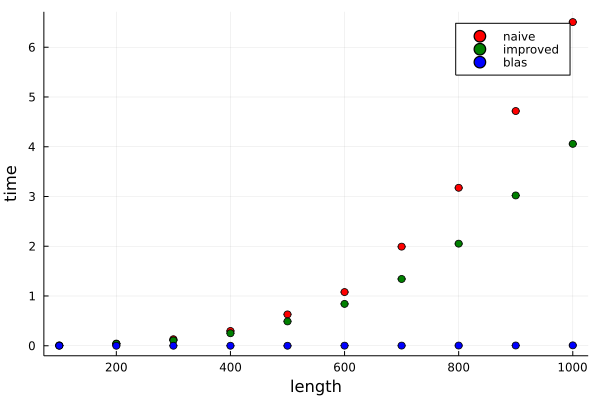

In [100]:
scatter([ data_frame_to_plot[data_frame_to_plot[:,2] .== "n", :].length data_frame_to_plot[data_frame_to_plot[:,2] .== "i", :].length data_frame_to_plot[data_frame_to_plot[:,2] .== "b", :].length],
    [ data_frame_to_plot[data_frame_to_plot[:,2] .== "n", :].time_mean  data_frame_to_plot[data_frame_to_plot[:,2] .== "i", :].time_mean data_frame_to_plot[data_frame_to_plot[:,2] .== "b", :].time_mean ],
    colour = [:red :green :blue],
    yerr = data_frame_to_plot.time_std,
    label = [ "naive" "improved" "blas"],
    xlab = "length",
    ylab = "time"
)

### 3. Wielomiany i aproksymacja średniokwadratowa

In [110]:
using Pkg
using Polynomials

### Julia - aproximation 

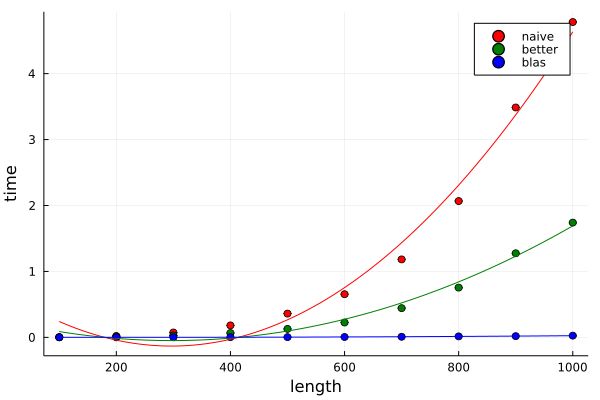

In [107]:
scatter([ df_to_plot[df_to_plot[:,2] .== "naive", :].length df_to_plot[df_to_plot[:,2] .== "better", :].length df_to_plot[df_to_plot[:,2] .== "blas", :].length],
    [ df_to_plot[df_to_plot[:,2] .== "naive", :].time_mean  df_to_plot[df_to_plot[:,2] .== "better", :].time_mean df_to_plot[df_to_plot[:,2] .== "blas", :].time_mean ],
    colour = [:red :green :blue],
    yerr = df_to_plot.time_std,
    label = [ "naive" "better" "blas"],
    xlab = "length",
    ylab = "time"
)

xs = df_to_plot[df_to_plot[:,2] .== "naive", 1]
ys_naive = df_to_plot[df_to_plot[:,2] .== "naive", 3]
ys_better = df_to_plot[df_to_plot[:,2] .== "better", 3]
ys_blas = df_to_plot[df_to_plot[:,2] .== "blas", 3]

fit_naive = fit(xs, ys_naive, 2)
plot!(fit_naive,  
    extrema(xs)..., 
    label = "",
    color = "red"
)

fit_better = fit(xs, ys_better, 2)
plot!(fit_better,  
    extrema(xs)..., 
    label = "",
    color = "green"
)

fit_blas = fit(xs, ys_blas, 2)
plot!(fit_blas,  
    extrema(xs)..., 
    label = "",
    color = "blue"
)

### C - aproximation 

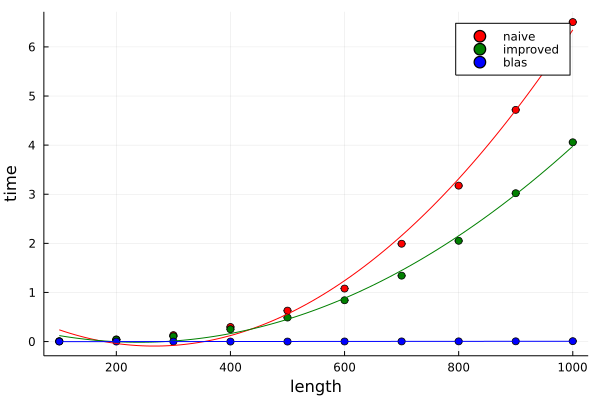

In [109]:
scatter([ data_frame_to_plot[data_frame_to_plot[:,2] .== "n", :].length data_frame_to_plot[data_frame_to_plot[:,2] .== "i", :].length data_frame_to_plot[data_frame_to_plot[:,2] .== "b", :].length],
    [ data_frame_to_plot[data_frame_to_plot[:,2] .== "n", :].time_mean  data_frame_to_plot[data_frame_to_plot[:,2] .== "i", :].time_mean data_frame_to_plot[data_frame_to_plot[:,2] .== "b", :].time_mean ],
    colour = [:red :green :blue],
    yerr = data_frame_to_plot.time_std,
    label = [ "naive" "improved" "blas"],
    xlab = "length",
    ylab = "time"
)

xs = data_frame_to_plot[data_frame_to_plot[:,2] .== "n", 1]
ys_naive = data_frame_to_plot[data_frame_to_plot[:,2] .== "n", 3]
ys_better = data_frame_to_plot[data_frame_to_plot[:,2] .== "i", 3]
ys_blas = data_frame_to_plot[data_frame_to_plot[:,2] .== "b", 3]

fit_polynomial_naive = fit(xs, ys_naive, 2)
plot!(fit_polynomial_naive,  
    extrema(xs)..., 
    label = "",
    color = "red"
)

fit_polynomial_better = fit(xs, ys_better, 2)
plot!(fit_polynomial_better,  
    extrema(xs)..., 
    label = "",
    color = "green"
)

fit_polynomial_blas = fit(xs, ys_blas, 1)
plot!(fit_polynomial_blas,  
    extrema(xs)..., 
    label = "",
    color = "blue"
)

### 4. Zniwelowanie efektu Rungego poprzez użycie wielomianów Czebyszewa

Rozważmy funkcję: \
$f(x) = \frac{1}{1+25x^{2}}$

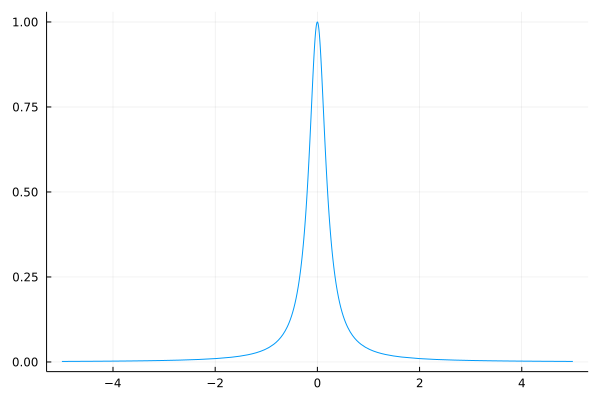

In [76]:
range = -5:1:5
f(x) = 1/(1+ 25*x^2)
plot(f,extrema(range)...,label="")

In [77]:
y_aprox = map(x -> 1/(1+25*x^2), range)
polynomial_aprox = fit(range,y_aprox,10)

Polynomial(0.9999999999999999 - 5.551115123125783e-17*x - 1.4017022018886478*x^2 - 3.885780586188048e-16*x^3 + 0.5038241865915477*x^4 - 1.5265566588595902e-16*x^5 - 0.06720281294416734*x^6 + 5.204170427930421e-18*x^7 + 0.0036079175300223593*x^8 + 1.0842021724855044e-19*x^9 - 6.555082721697598e-5*x^10)

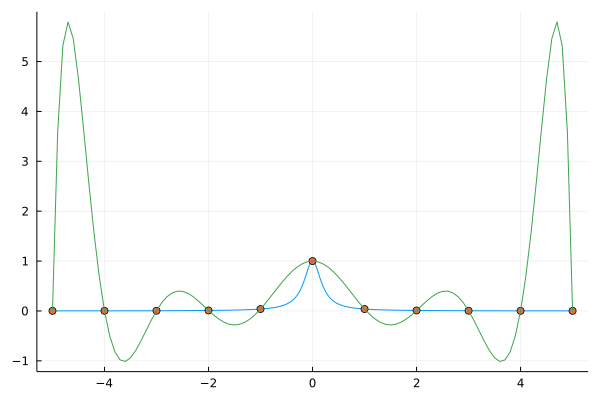

In [78]:
scatter!(range, y_aprox, label="")
plot!(polynomial_aprox,  extrema(range)..., label="")

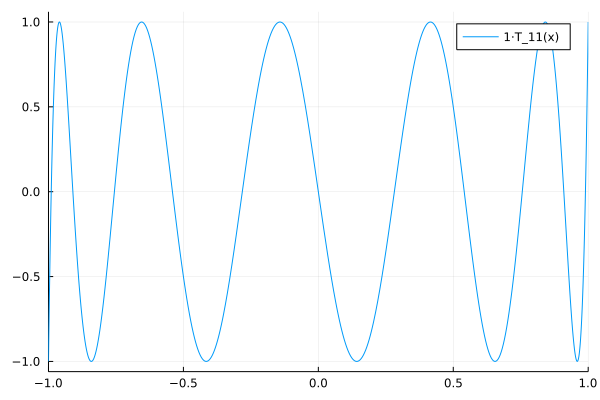

In [79]:
chebyshev_base = [0,0,0,0,0,0,0,0,0,0,0,1]
chebyshev_poly = ChebyshevT(chebyshev_base)
plot(chebyshev_poly)

In [80]:
che_poly_zeros = Polynomials.roots(chebyshev_poly)
che_poly_zeros = 5 * che_poly_zeros
y_aprox_che = map(x -> 1/(1+25*x^2), che_poly_zeros)
poly_aprox_che = fit(che_poly_zeros,y_aprox_che,10)

Polynomial(1.0 + 1.4710455076283324e-15*x - 0.7819469334295069*x^2 - 5.273559366969494e-16*x^3 + 0.1742308824812534*x^4 + 1.6653345369377348e-16*x^5 - 0.015896952501883936*x^6 + 0.0006352311044059432*x^8 + 4.743384504624082e-20*x^9 - 9.234352440848136e-6*x^10)

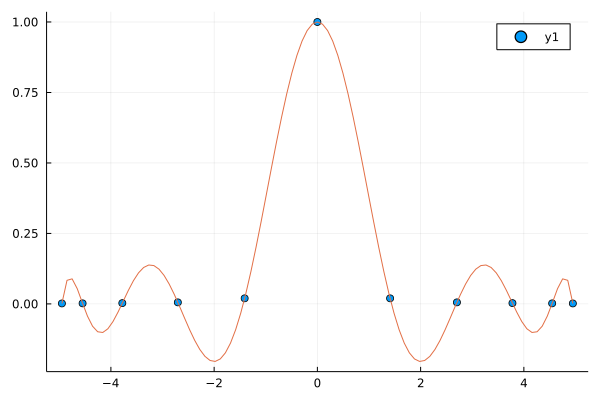

In [81]:
scatter(che_poly_zeros, y_aprox_che)
plot!(poly_aprox_che,  extrema(che_poly_zeros)..., label="")

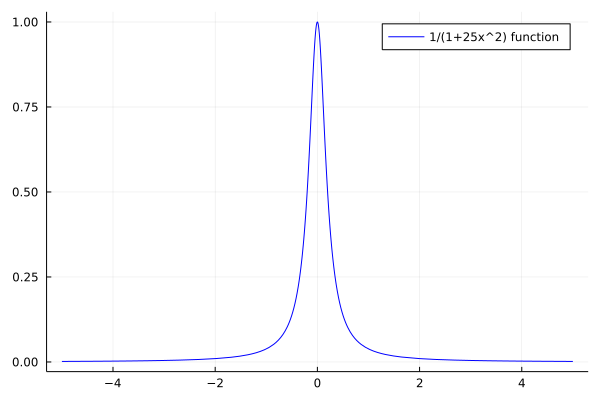

In [84]:
plot(f,  extrema(range)..., 
    label="1/(1+25x^2) function",
    color = "blue"
)

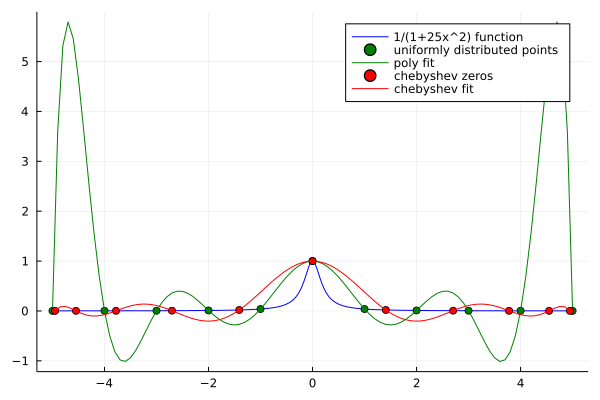

In [85]:
plot(f,  extrema(range)..., 
    label="1/(1+25x^2) function",
    color = "blue"
)
scatter!(range, y_aprox, 
    label="uniformly distributed points",
    color = "green"
)
plot!(polynomial_aprox,  extrema(range)..., 
    label="poly fit",
    color = "green"
)
scatter!(che_poly_zeros, y_aprox_che, 
    label="chebyshev zeros",
    color = "red"
)
plot!(poly_aprox_che,  extrema(che_poly_zeros)..., 
    label="chebyshev fit",
    color = "red"
)

Dzięki wyboru punktów metodą Chebysheva zanika efekt Rungego - widoczny na skrajach przedziału.

### 5. Pade vs Taylor 

In [88]:
using TaylorSeries

In [89]:
t = Taylor1(Float64, 10)
myfun(x) = log(1+x)/x
p = myfun(t)

 1.0 - 0.5 t + 0.3333333333333333 t² - 0.25 t³ + 0.2 t⁴ - 0.16666666666666666 t⁵ + 0.14285714285714285 t⁶ - 0.125 t⁷ + 0.1111111111111111 t⁸ - 0.1 t⁹ + 𝒪(t¹⁰)

In [90]:
p = Polynomial(p.coeffs)

Polynomial(1.0 - 0.5*x + 0.3333333333333333*x^2 - 0.25*x^3 + 0.2*x^4 - 0.16666666666666666*x^5 + 0.14285714285714285*x^6 - 0.125*x^7 + 0.1111111111111111*x^8 - 0.1*x^9)

In [91]:
pade = Polynomials.PolyCompat.PadeApproximation.Pade(p, 2, 2)

Polynomials.PolyCompat.PadeApproximation.Pade{Float64, Float64}(Polynomial(1.0 + 0.6999999999999987*x + 0.03333333333333298*x^2), Polynomial(1.0 + 1.1999999999999986*x + 0.29999999999999905*x^2), :x)

In [92]:
fieldnames(typeof(pade))

(:p, :q, :var)

In [94]:
pade_f(x) = pade.p(x) / pade.q(x)
taylor_f(x) = p(x)

taylor_f (generic function with 1 method)

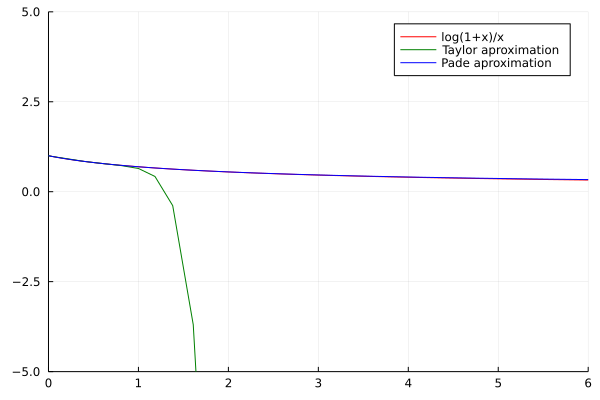

In [96]:
plot(myfun,
    xlims = (0,6),
    ylims = (-5,5),
    label="log(1+x)/x",
    color = "red"
)
plot!(taylor_f,
    label="Taylor aproximation",
    color = "green"
)
plot!(pade_f,
    label="Pade aproximation",
    color = "blue"
)